 **INTRODUCTION:**
Talking about the past decade, online shopping market has reached new heights. The e-commerce industry has
grown at a rapid pace in this period and now days it’s an essential part of human lives all over the world. Online
shopping now has a vast variety of products which are being purchased on a simple web application hassle free.
The continuous improvement in the whole process by use of growing technology has brought a wide range of
services to give the customer real time shopping experience. One of these services include customer reviews
which are found to be very helpful in providing a full-fledged information of the product. Not only the images,
prices, specifications but the reviews also are a part of a product catalogue now days. In this project we will
focus on improving review readability for the customer using Natural Language Processing Techniques.

PROBLEM STATEMENT:
In this project we have to build a system which summarizes the customer reviews of a particular product into a
bunch of keywords, so that when a customer goes to a product page, he/she doesn’t have to read long reviews.
Instead he/she can make up his/her mind based on the product average rating and summarized keywords of the
review.
For this problem you may use any tools and techniques you like. The data consists of reviews and ratings
information of the products which are being sold by the client via online website. The data description is as
follows:


**DATA DESCRIPTION:**

1_ IC – Item Code of the product, e.g. B016MF3P3K

2) Reviewer_Name - Name of the reviewer

3) Useful- Number of useful votes (upvotes) of the review

4) Prod_meta- a dictionary of the product metadata. It contains only additional information about the
product, if any available.

5) Review- text of the review


6)Rating- rating given to the product by the reviewer.

7)Rev_summ- summary of the review

8) Review_timestamp- time when the review has been posted (unix time format)

9) Review_Date- Date when the review has been posted

10)Prod_img- images that users post after they have received the 
product

11) Rev_verify- Flag to represent whether the review has been verified or not. (True/False)

***Mounting Drive***


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing the Data**

In [4]:
import pandas as pd
data= pd.read_json('/content/gdrive/My Drive/Cell_Phones_and_Accessories.json')

In [5]:
data.head(5)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,5,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,5,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None
3,3,True,"02 27, 2013",B0089CH3TM,{'Color:': ' Green'},Alyse,"The material and fit is very nice, but the col...",Good case overall,1361923200,3,None
4,4,True,"12 19, 2013",B00AKZWGAC,None,TechGuy,This last me about 3 days till i have to charg...,Awesome Battery,1387411200,None,None


**Famliarisation with the Dataset**

In [6]:
data.shape

(760450, 11)

In [7]:
data.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

In [8]:
data.dtypes

Rating               int64
Rev_verify            bool
Review_Date         object
IC                  object
Prod_meta           object
Reviewer_Name       object
Review              object
Rev_summ            object
Review_timestamp     int64
Useful              object
Prod_img            object
dtype: object

***Converting rating in 0 and 1 to get the counts of bad and good review *** 

In [9]:
# Give reviews with rating>3 a positive rating(1), and reviews with a rating<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with rating less than 3 to be positive and vice-versa
actualScore = data['Rating']
positiveNegative = actualScore.map(partition) 
data['Rating'] = positiveNegative
print("Number of data points in our data", data.shape)
data.head(3)

Number of data points in our data (760450, 11)


,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,1,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None
1,1,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None
2,1,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None


In [10]:
print(data[data['Rating']==1].shape)
print(data[data['Rating']==0].shape)



(666989, 11)
(93461, 11)


From the above data we can say that count of the  bad reviewed products are lesser

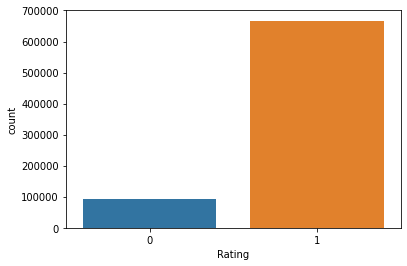

In [11]:
import seaborn as sns
sns.countplot(x="Rating", data=data)

*Combining review and summary features*

In [12]:
data['Review_summ']=data['Review']+ '  ' + data['Rev_summ']

***Null/missing value Analysis***

In [13]:
data.isnull().sum()[data.isnull().sum()>0]

Prod_meta        352624
Reviewer_Name        91
Review              530
Rev_summ            355
Useful           698250
Prod_img         742256
Review_summ         848
dtype: int64

*Our main focus will be review_summ column , therefore we can see that there are 848 columns which have no review in it ,so these will be dropped*

**Dropping Null Valued Review_summ rows**

In [15]:
df = data.dropna(axis=0, subset=['Review_summ'])

In [17]:
df.shape

(759602, 12)

**Exploring the Unique number of product**

In [19]:
data.IC.nunique(dropna = True)

48134

There are 48134 unique products in the dataset

**Preprocessing Description**

In the Preprocessing phase we do the following in the order below:-

a) Begin by removing the html tags

b) Remove any punctuations or limited set of special characters like , or . or # etc.

c) Check if the word is made up of english letters and is not alpha-numeric

d) Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

e) Convert the word to lowercase

f) Remove Stopwords

In [20]:
# printing some random reviews
rev_0 = df['Review_summ'].values[0]
print(rev_0)
print('='*50)

rev_50 = df['Review_summ'].values[50]
print(rev_50)
print('='*100)

rev_100 = df['Review_summ'].values[100]
print(rev_100)
print('='*50)

Bought it for my husband. He's very happy with it  He's very happy with
great  Five Stars
Very good and superior quality, looks great. My wife has been using it from last couple of months and its still almost intact. The call pick up feature while the top cover is on is not that great, it hardly worked but we were not looking for it anyhow. As a case, this is probably way better then a lot out in the market. We will for sure buy it again as we look for a replacement in future.  Very nice and good quality!!!


In [21]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(rev_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Bought it for my husband. He's very happy with it  He's very happy with


In [22]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
rev_100 = decontracted(rev_100)
print(rev_100)
print("="*50)

Very good and superior quality, looks great. My wife has been using it from last couple of months and its still almost intact. The call pick up feature while the top cover is on is not that great, it hardly worked but we were not looking for it anyhow. As a case, this is probably way better then a lot out in the market. We will for sure buy it again as we look for a replacement in future.  Very nice and good quality!!!


In [24]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Review_summ'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 759602/759602 [03:32<00:00, 3572.53it/s]


In [27]:
 #Printing a sample review after the preprocessing and cleaning of the text.
preprocessed_reviews[100]

'good superior quality looks great wife using last couple months still almost intact call pick feature top cover not great hardly worked not looking anyhow case probably way better lot market sure buy look replacement future nice good quality'

In [26]:
df['preprocessed_reviews']=preprocessed_reviews

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df.head(3)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img,Review_summ,preprocessed_reviews
0,1,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None,Bought it for my husband. He's very happy with...,bought husband happy happy
1,1,True,"01 9, 2016",B016MF3P3K,None,Denise Lesley,Great screen protector. Doesn't even seem as ...,Five Stars,1452297600,None,None,Great screen protector. Doesn't even seem as ...,great screen protector not even seem though fi...
2,1,True,"04 21, 2013",B008DC8N5G,None,Emir,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,1366502400,None,None,Saved me lots of money! it's not gorilla glass...,saved lots money not gorilla glass careful sub...


*Preparing a list of all the unique products in order to have further analysis*

In [29]:
IC_unique=df['IC'].unique().tolist()

In [30]:
len(IC_unique)

48133

**Review Combination for each product**

In [31]:
rev=[]
for i in range(0,len(IC_unique)):
  v=df[df['IC']==IC_unique[i]].preprocessed_reviews
  v = [' '.join(v[:])]
  rev.append(v)



**Creating New Data Frame for products and its combined Reviews**

In [32]:
df_new = pd.DataFrame(list(zip(IC_unique, rev)), 
               columns =['IC', 'review'])

In [33]:
df_new.head(4)


,IC,review
0,B009XD5TPQ,[bought husband happy happy good product exact...
1,B016MF3P3K,[great screen protector not even seem though f...
2,B008DC8N5G,[saved lots money not gorilla glass careful su...
3,B0089CH3TM,[material fit nice color neon green expected w...


In [34]:
df_new.review[0]

['bought husband happy happy good product exactly description says recommend buying product leather case holder nice case medium larger smartphones droid razor maxx fits nicely belt clip strong spring steel magnetic clasp holds well magnetic design nice leather smartphone case appears excellent product fits phone nicely even hard shell back phone like fact belt loop well clip slides belt loop ensures case not come belt yet option using clip quickly remove phone time tell concerning durability price hard beat exceptional value great fit iphone protective case yes read correctly needed belt clip hold iphone thin protective case already works perfectly price good works iphone ballistic quality case feels nice solid complaint little larger support protective cases phone since not use one lot extra room phone move around nice solid case phone large enough support protective cases good phone holster belt loops clip phone fits well appearance described good phone holster reasonable price july

**Saving the new Data Frame**

In [35]:
df_new.to_csv('review_data.csv') 

In [36]:
df_new.shape

(48133, 2)

**Tfidf Featurisation**

In [79]:
#Vectorizing using tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
keywords=[]
top_n = 30
for i in df_new['review']:
  tf_idf_vect = TfidfVectorizer()
  tf_idf_vect.fit(i)
  Tf_idf_doc = tf_idf_vect.transform(i)
  indices = np.argsort(tf_idf_vect.idf_)[::-1]
  features = tf_idf_vect.get_feature_names()
  features = [features[i] for i in indices[:top_n]]
  keywords.append(features)

*In the above block we have  one by one featurised each review on tfidf  and selected top 30 top scored words , which we have called keywords and lastly we have appended all in a list .*

**Function to convert the list into string for each data in review , review keywords**

In [38]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
     
    # return string   
    return (str1.join(s)) 
        
        




In [86]:
s=[]
for i in range(len(df_new['review'])):
  s.append(listToString(df_new['review'][i]))
df_new['review']=s

In [84]:
s=[]
for i in range(len(df_new['Review_Keywords'])):
  s.append(listToString(df_new['Review_Keywords'][i]))
df_new['Review_Keywords']=s

***Below is the final DataFrame which has product details in IC , combined review in review and keywords from that review in Review_Keywords columns***

In [87]:
df_new.head(5)

,IC,review,Review_Keywords
0,B009XD5TPQ,bought husband happy happy good product exactl...,yet explained holding holder hold high hedocel...
1,B016MF3P3K,great screen protector not even seem though fi...,wrong galaxy four free friction front frustrat...
2,B008DC8N5G,saved lots money not gorilla glass careful sub...,youtube frame glue gloves glasses glass giving...
3,B0089CH3TM,material fit nice color neon green expected wo...,yellow front fits five fixed flash flat flexib...
4,B00AKZWGAC,last days till charge take forever charge make...,zl friend frustratingly front frilly friggin f...


Saving The DataFrame

In [92]:
df_new.to_csv('/content/gdrive/My Drive/review_data.csv')

**Conclusion:**

In this project we have imported the dataset , combined review and summary column in order to have information in place , then we have perfomed Null/Missing value analysis and dropped all the null valued review rows.

Then based on the product we have combined all the review based on each and every product and performed data cleansing .

Taken all the combined, cleaned reviews and featurised them on tfidf and based on the score we have extracted top 30 keywords for each combined review of each product and created the final data Frame ,comprising of Product Id (IC) , combined reviews , Review_Keywords.

END